# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.



**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

### Постановка задачи и выяснение общей картины
1. **Цель**:   Повышение продаж, за счет внедрения нового сервиса, позволив пользователям редактировать комментарии и описание к товарам. Сделав описание товаров более информативным для потенциальных покупателей.
    
    **Ожидаемый эффект** от внедрения нашего решения - снижение нагрузки на модераторов, за счет автоматизации проверки на токсичность комментариев пользователей. 
2. **Применение:** Наше решение на вход будет принимать массив или  строку для классификации ее на токсичность. Полная схема взаимодействия с дргуими сервисами проекта не предоставлена. 
3. **Текущее решение:** Данные отсутсвуют
4. **Задача:** Тип задачи - классификация. Данные уже размечены, поэтому будетм использовать обучение с учителем. 
5. **Производительность:** Критериии производительности отсутсвуют
6. **Оценка:** В качестве оценки работы моделей будет использоваться F1 мера.
7. **Предположения:** стоит учесть тот факт, что пропуск токсичного коментария несет потенциальные финансовые и репутационные потери. 




### План работ
1. Анализ данных
2. Очистка данных от служебных символов и знаков препинания
3. Лемматизация данных
4. Подготовка датасетов для обучения и проверки моделей
5. Выбрать наилучшую модель для дальнейшего анализа
6. Проверка модели на тестовом наборе

## Подготовка

#### Анализ данных

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import pandas as pd
import numpy as np
from random import shuffle
import re
from nltk.stem import WordNetLemmatizer
import spacy
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import time
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [32]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Shad/toxic/toxic_comments.csv')

In [33]:
df.shape

(159571, 2)

In [34]:
df.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [35]:
df.isnull().mean()

text     0.0
toxic    0.0
dtype: float64

In [36]:
(df['toxic'] == 0).mean()

0.8983211235124177

In [37]:
(df['toxic'] == 1).mean()

0.10167887648758234

Есть дисбаланс классов

#### Очистка и лемматизация

In [38]:
nlp =  spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

In [39]:
def lemmatize(text):
    doc = nlp(text)
    lemm_text = " ".join([token.lemma_ if token.lemma_ !='-PRON-' else token.text for token in doc])      
    return lemm_text

In [40]:
def clear_txt(text):
    return (" ".join(re.sub(r'[^a-zA-Z\']', ' ', text).lower().split()))

<div class="alert alert-block alert-success">
<b>Успех:</b> Лемматизация и очистка определена корректно.
</div>

In [41]:
%%time
df['lemma_text'] = df['text'].apply(lambda x: lemmatize(clear_txt(x)))


CPU times: user 1min 43s, sys: 90.4 ms, total: 1min 43s
Wall time: 1min 43s


In [42]:
df

,text,toxic,lemma_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i be really not try to edit war it hav...
3,"""\nMore\nI can't make any real suggestions on ...",0,much i can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,and for the 2 time of ask when your view compl...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there s no actual article for pros...
159569,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


#### Разбивка датасета

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df['lemma_text'], df['toxic'], test_size = 0.3, random_state = 42)

In [44]:
#X_train, X_valid, y_train, y_valid = train_test_split(X_temporary, y_temporary, test_size=0.2,random_state = 42)

## Обучение

#### Подготовка Pipeline

In [45]:
pipe_fit = Pipeline(steps = [
                             ('tfidf', TfidfVectorizer(stop_words=stopwords)),
                             ('model', LogisticRegression(random_state=42))
                            ])

In [46]:
params = [
          {
              'model': [LogisticRegression(random_state=42,max_iter=1000)],
              'tfidf__ngram_range': [(1,1), (2, 2)]    
          },

          {
              'model': [DecisionTreeClassifier(random_state=42)],
              'model__max_depth': [10, 20],
              'tfidf__ngram_range': [(1,1), (2, 2)] 
          },

          {
              'model': [RandomForestClassifier(random_state=42)],
              'model__n_estimators': [10, 20],
              'tfidf__ngram_range': [(1,1), (2, 2)] 
          }
]

In [47]:
grid = GridSearchCV(pipe_fit, param_grid=params, verbose=True, n_jobs=5, cv=3,  scoring='f1')

In [48]:
%%time
grid.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed: 43.9min finished


CPU times: user 17.8 s, sys: 9.91 s, total: 27.7 s
Wall time: 44min 7s


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [49]:
grid.best_score_

0.7167614508103185

In [50]:
pd.DataFrame(grid.cv_results_).sort_values(by="mean_test_score", ascending=False)[['param_tfidf__ngram_range',
                                                                                  'param_model__max_depth',
                                                                                  'param_model__n_estimators',
                                                                                  'mean_test_score',
                                                                                  'param_model']]

,param_tfidf__ngram_range,param_model__max_depth,param_model__n_estimators,mean_test_score,param_model
0,"(1, 1)",NaN,NaN,0.716761,"LogisticRegression(C=1.0, class_weight=None, d..."
8,"(1, 1)",NaN,20,0.669408,"RandomForestClassifier(bootstrap=True, ccp_alp..."
4,"(1, 1)",20,NaN,0.664068,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
6,"(1, 1)",NaN,10,0.652290,"RandomForestClassifier(bootstrap=True, ccp_alp..."
2,"(1, 1)",10,NaN,0.605628,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
9,"(2, 2)",NaN,20,0.434921,"RandomForestClassifier(bootstrap=True, ccp_alp..."
7,"(2, 2)",NaN,10,0.424107,"RandomForestClassifier(bootstrap=True, ccp_alp..."
5,"(2, 2)",20,NaN,0.211810,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
1,"(2, 2)",NaN,NaN,0.183083,"LogisticRegression(C=1.0, class_weight=None, d..."
3,"(2, 2)",10,NaN,0.160776,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."


#### Вывод
Модель логистическая регрессия выдала лучший результат 0,70

#### Финальные проверки

Создадим функцию для построения графиков 

In [51]:
def prc_graph(y_train, predict_proba):
  precision, recall, thresholds = precision_recall_curve(y_train, predict_proba[:,1])
  plt.plot(thresholds, precision[:-1], label = "presision")
  plt.plot(thresholds, recall[:-1], label = "recall")
  plt.xlabel("thresholds")
  plt.legend(loc="center left")
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.grid(True)
  plt.title('presision recall')

Функция поиска лучшего порога и метрики

In [52]:
def best_predict(model, X, y):
  predict_proba = model.predict_proba(X)
  best_f1 = 0
  best_threshold  = 0
  for threshold in np.arange(0.1, 0.8, 0.03):
    predict = (predict_proba[:,1] > threshold)*1
    f1 = f1_score(y, predict)
    if f1 > best_f1:
      best_f1 = f1
      best_threshold = threshold
  prc_graph(y, predict_proba)
  predict = (predict_proba[:,1] > best_threshold)*1
  return best_f1, best_threshold, predict

In [53]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 1))

In [54]:
X_train = count_tf_idf.fit_transform(X_train.values.astype('U'))

In [55]:
X_test = count_tf_idf.transform(X_test.values.astype('U'))

In [56]:
clr = LogisticRegression()

In [57]:
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

(0.7868542629147417, 0.25, array([0, 0, 0, ..., 1, 0, 0]))

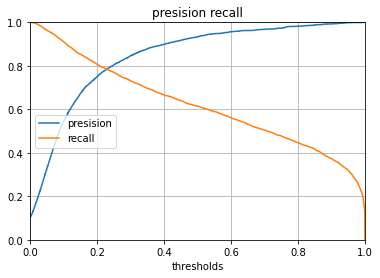

In [58]:
best_predict(clr, X_test, y_test)

Получен результат: метрика f1 0.78, порог для модели 0.25

## Выводы

1. Задача по поставленным условиям решена.
2. Данные перед обучением были подготовлены по следующему алгоритму: 
   
    * Очистка и лемматизация 
    * разбиение на Тренеровочный, валидационный и тестовый датасеты.
3. Обучены были три модели:
   
    * Решающее деревоо
    * Линейная регрессия
    * Случайный лес

Модели обучались с разными вариантами трансформации данных, униграма и биграма. Лучшие показатели были при использовании униграмы. На этот счет есть предположение, что ругательные слова чаще всего употребляются с вполне приемлемыми словами. При использовании биграмы модели сложнее провести классификацию текста.


4. Замечание касательно алгоритма работы. По условию задачи необходимо определить токсичный комментарий (1) или позитивный (0). Токсичные идут на проверку, позитивные в публикацию. По логике как мне кажется мы должны делать наоборот, определять позитивный комментарий как 1 и пропускать его, а токсичный отправлять на модерацию. При такой схеме ошибка модели не так страшна, если модель ошибется то положительный комментарий пойдет на модерацию. Но токсичный текс не пройдет. 